In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## f_disk en funcion del tiempo - GADGET

In [12]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
#     print aexp[isnap]

#     lala

    for i in range(0,2):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h
        
        r200 = r200*aexp[isnap]/h
        
#         print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        limit_gas   = np.where(rgas<r200)
        rgas_sort   = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
        
        Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])
    

    #------------------ calculamos M90------------------------------------------
        razon = Mgal_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

    #--------------------------------------------         
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
#--------------------------------------------------------------   
        Mgas_50 = Mc_gas[np.where(rgas_sort < r50)][-1]
        Mdrk_50 = Mc_drk[np.where(rdrk_sort < r50)][-1]

        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vr50 = Vtot[np.where(rtot_sort < r50)][-1]
        
        fdisk = Vr50 / np.sqrt(G*M50*1e10/r50)
        
#         print fdisk
        
#--------------------------------------------------------------------------------------------------------------------

        archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
        archivo1.write(str('%12.6f'% time) +'\t'+
                       str('%12.6f'% fdisk) +'\t'+
                       str('%12.6f'% r50) +'\t'+
                       str('%12.6f'% np.log10(M_gal*1e10)) +'\t'+
                       str('%12.6f'% np.log10(M50*1e10)) +'\t'+
                       str('%12.6f'% np.log10(Mgas_50*1e10)) +'\t'+
                       str('%12.6f'% np.log10(Mdrk_50*1e10)) +'\t'+
                       str('%12.6f'% Vr50) +'\n')
        archivo1.close()   



/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in divide


## f_disk en funcion del tiempo - GASOLINE

In [6]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np


G = 4.299e-6
a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    for i in range(0,2):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

        pdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Coordinates'].value
        mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value


    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0]) #*aexp
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

        xgas = (pgas[:,0]-cm[0])
        ygas = (pgas[:,1]-cm[1])
        zgas = (pgas[:,2]-cm[2])
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        xdrk = (pdrk[:,0]-cm[0])
        ydrk = (pdrk[:,1]-cm[1])
        zdrk = (pdrk[:,2]-cm[2])
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(rstr<rgal)
        r_sort = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
    
        limit_gas   = np.where(rgas<r200)
        rgas_sort   = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])

        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])


        Mgal_str = cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]

        Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])

        Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])

    #------------------ calculamos M90------------------------------------------
        razon = Mgal_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]
        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]
                
#--------------------------------------------------------------       
        rtot= concatenate([rstr, rgas, rdrk])
        mtot= concatenate([mstr, mgas, mdrk])

        limit_tot = np.where(rtot<r200)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])

        Mc_tot = cumsum(mtot[limit_tot][rtot_indice])
#--------------------------------------------------------------
        Mgas_50 = Mc_gas[np.where(rgas_sort < r50)][-1]
        Mdrk_50 = Mc_drk[np.where(rdrk_sort < r50)][-1]
    
        Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
        Vr50 = Vtot[np.where(rtot_sort < r50)][-1]
        
        fdisk = Vr50 /np.sqrt(G*M50/r50)
        
#         print fdisk, time
        
#--------------------------------------------------------------------------------------------------------------------

        archivo1 =  open('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_fdisk_time.dat','a')
        archivo1.write(str('%12.6f'% time) +'\t'+
                       str('%12.6f'% fdisk) +'\t'+
                       str('%12.6f'% r50) +'\t'+
                       str('%12.6f'% np.log10(M_gal)) +'\t'+
                       str('%12.6f'% np.log10(M50)) +'\t'+
                       str('%12.6f'% np.log10(Mgas_50)) +'\t'+
                       str('%12.6f'% np.log10(Mdrk_50)) +'\t'+
                       str('%12.6f'% Vr50) +'\n')
        archivo1.close()

/home/omarioni/.conda/envs/conda-env/lib/python2.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in divide


In [13]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_fdisk_time.dat')
time_M31gd  = M31_gd[:,0]
fdisk_M31gd = M31_gd[:,1]
r50_M31gd   = M31_gd[:,2]
Mgal_M31gd  = M31_gd[:,3]
M50_M31gd   = M31_gd[:,4]
Mg50_M31gd  = M31_gd[:,5]
Mdm50_M31gd = M31_gd[:,6]
Vr50_M31gd  = M31_gd[:,7]

#------------------------------------------------------------------------------------------

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_fdisk_time.dat')
time_MWgd  = MW_gd[:,0]
fdisk_MWgd = MW_gd[:,1]
r50_MWgd   = MW_gd[:,2]
Mgal_MWgd  = MW_gd[:,3]
M50_MWgd   = MW_gd[:,4]
Mg50_MWgd  = MW_gd[:,5]
Mdm50_MWgd = MW_gd[:,6]
Vr50_MWgd  = MW_gd[:,7]


#------------------------------------------------------------------------------------------

M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_fdisk_time.dat')
time_M31gs  = M31_gs[:,0]
fdisk_M31gs = M31_gs[:,1]
r50_M31gs   = M31_gs[:,2]
Mgal_M31gs  = M31_gs[:,3]
M50_M31gs   = M31_gs[:,4]
Mg50_M31gs  = M31_gs[:,5]
Mdm50_M31gs = M31_gs[:,6]
Vr50_M31gs  = M31_gs[:,7]


#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_fdisk_time.dat')
time_MWgs  = MW_gs[:,0]
fdisk_MWgs = MW_gs[:,1]
r50_MWgs   = MW_gs[:,2]
Mgal_MWgs  = MW_gs[:,3]
M50_MWgs   = MW_gs[:,4]
Mg50_MWgs  = MW_gs[:,5]
Mdm50_MWgs = MW_gs[:,6]
Vr50_MWgs  = MW_gs[:,7]



## f_disk vs time

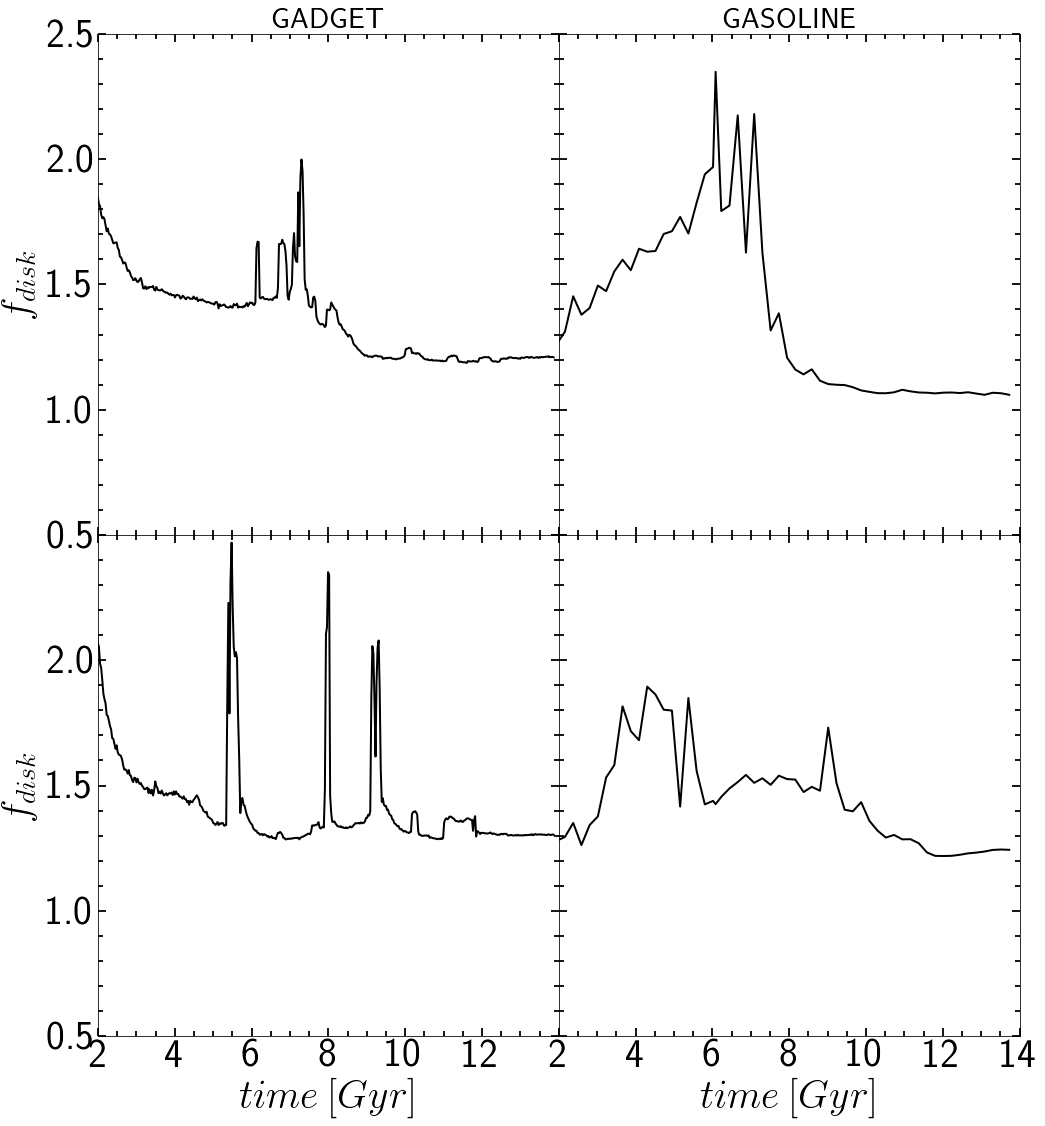

In [15]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
# from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))# sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, fdisk_M31gd,'-', lw=2, color = 'k')
ax[0,0].set_xlim(2,14)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(0.5,2.5)
ax[0,0].set_yticks([0.5,1.,1.5,2.,2.5])
ax[0,0].set_yticklabels([0.5,1.,1.5,2.,2.5])
ax[0,0].set_ylabel(r'$f_{disk}$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, fdisk_M31gs,'-', lw=2, color = 'k')
ax[0,1].set_xlim(2,14)
ax[0,1].set_xticks([2,4,6,8,10,12,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(0.5,2.5)
ax[0,1].set_yticks([0.5,1.,1.5,2.,2.5])
ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, fdisk_MWgd,'-', lw=2, color = 'k')
ax[1,0].set_xlim(2,14)
ax[1,0].set_xticks([2,4,6,8,10,12,14])
ax[1,0].set_xticklabels([2,4,6,8,10,12])
ax[1,0].set_ylim(0.5,2.5)
ax[1,0].set_yticks([0.5,1.,1.5,2.,2.5])
ax[1,0].set_yticklabels([0.5,1.,1.5,2.0])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$f_{disk}$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, fdisk_MWgs,'-', lw=2, color = 'k')
ax[1,1].set_xlim(2,14)
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
ax[1,1].set_ylim(0.5,2.5)
ax[1,1].set_yticks([0.5,1.,1.5,2.,2.5])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/fdisk_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()


## r_50 vs time

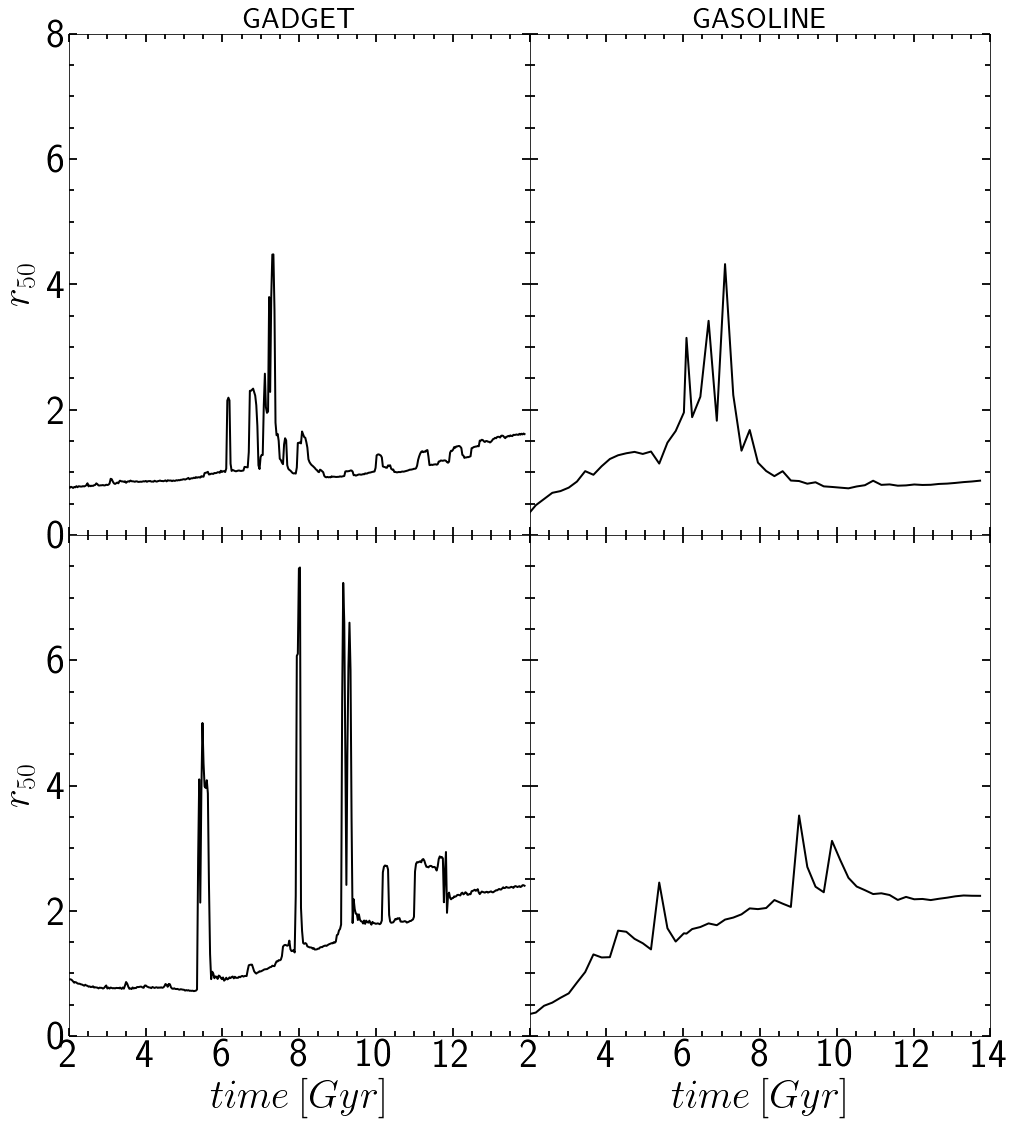

In [16]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, r50_M31gd,'-', lw=2, color = 'k')
ax[0,0].set_xlim(2,14)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(0,8)
ax[0,0].set_yticks([0,2,4,6,8])
ax[0,0].set_yticklabels([0,2,4,6,8])
ax[0,0].set_ylabel(r'$r_{50}$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, r50_M31gs,'-', lw=2, color = 'k')
ax[0,1].set_xlim(2,14)
ax[0,1].set_xticks([2,4,6,8,10,12,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(0,8)
ax[0,1].set_yticks([0,2,4,6,8])
ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, r50_MWgd,'-', lw=2, color = 'k')
ax[1,0].set_xlim(2,14)
ax[1,0].set_xticks([2,4,6,8,10,12,14])
ax[1,0].set_xticklabels([2,4,6,8,10,12])
ax[1,0].set_ylim(0,8)
ax[1,0].set_yticks([0,2,4,6])
ax[1,0].set_yticklabels([0,2,4,6])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$r_{50}$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, r50_MWgs,'-', lw=2, color = 'k')
ax[1,1].set_xlim(2,14)
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
ax[1,1].set_ylim(0,8)
ax[1,1].set_yticks([0,2,4,6])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/r50_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()


## M_gal vs time

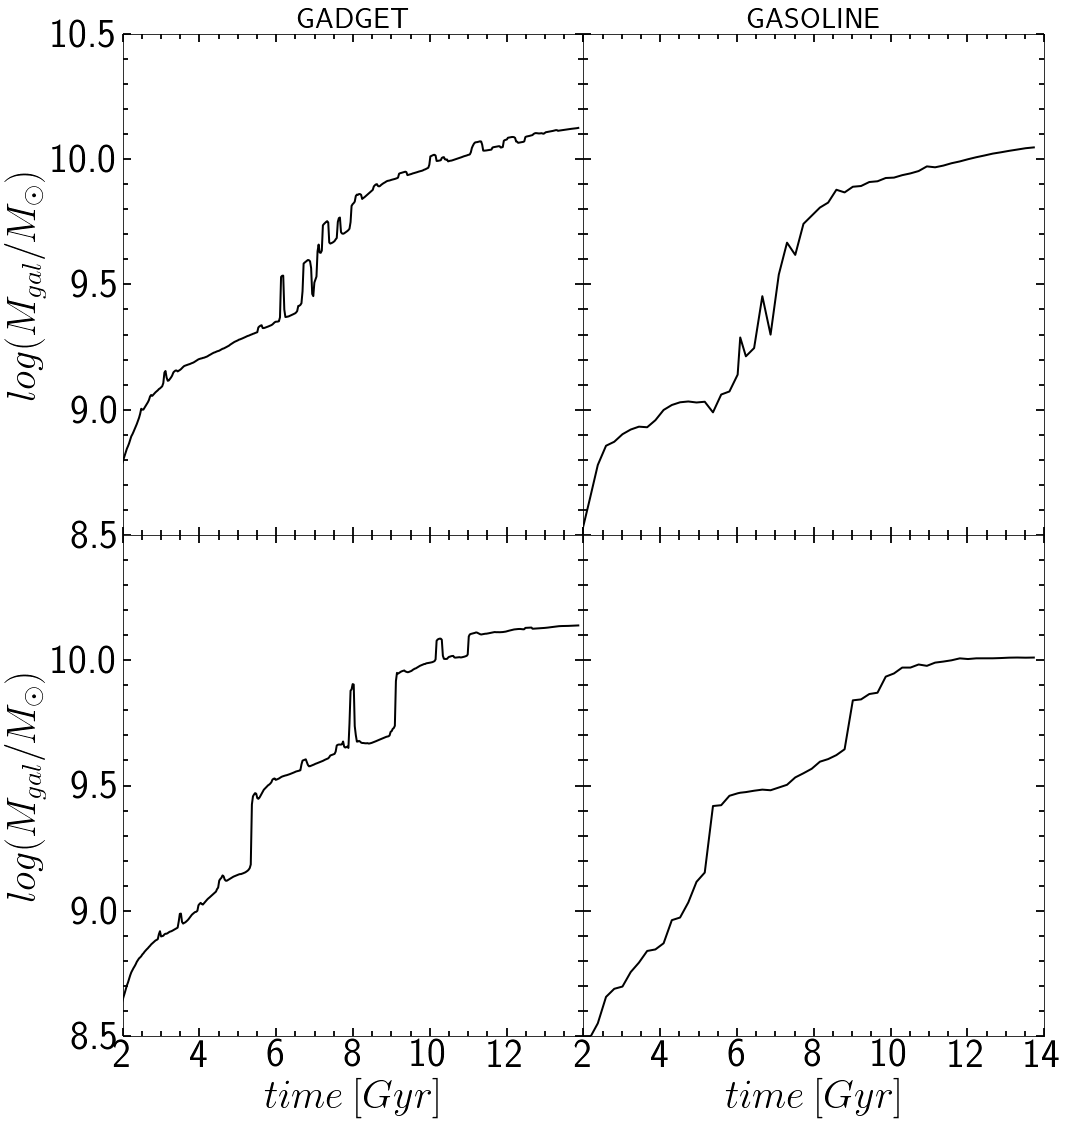

In [17]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, Mgal_M31gd,'-', lw=2, color = 'k')
ax[0,0].set_xlim(2,14)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(8.5,10.5)
ax[0,0].set_yticks([8.5,9.,9.5,10.,10.5])
ax[0,0].set_yticklabels([8.5,9.,9.5,10.,10.5])
ax[0,0].set_ylabel(r'$log(M_{gal}/M_{\odot})$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, Mgal_M31gs,'-', lw=2, color = 'k')
ax[0,1].set_xlim(2,14)
ax[0,1].set_xticks([2,4,6,8,10,12,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(8.5,10.5)
ax[0,1].set_yticks([8.5,9.,9.5,10.,10.5])
ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, Mgal_MWgd,'-', lw=2, color = 'k')
ax[1,0].set_xlim(2,14)
ax[1,0].set_xticks([2,4,6,8,10,12])
ax[1,0].set_xticklabels([2,4,6,8,10,12])
ax[1,0].set_ylim(8.5,10.5)
ax[1,0].set_yticks([8.5,9.,9.5,10.])
ax[1,0].set_yticklabels([8.5,9.,9.5,10.])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$log(M_{gal}/M_{\odot})$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, Mgal_MWgs,'-', lw=2, color = 'k')
ax[1,1].set_xlim(2,14)
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
ax[1,1].set_ylim(8.5,10.5)
ax[1,1].set_yticks([8.5,9.,9.5,10.])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Mgal_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()


## Vcirc en r50 vs time

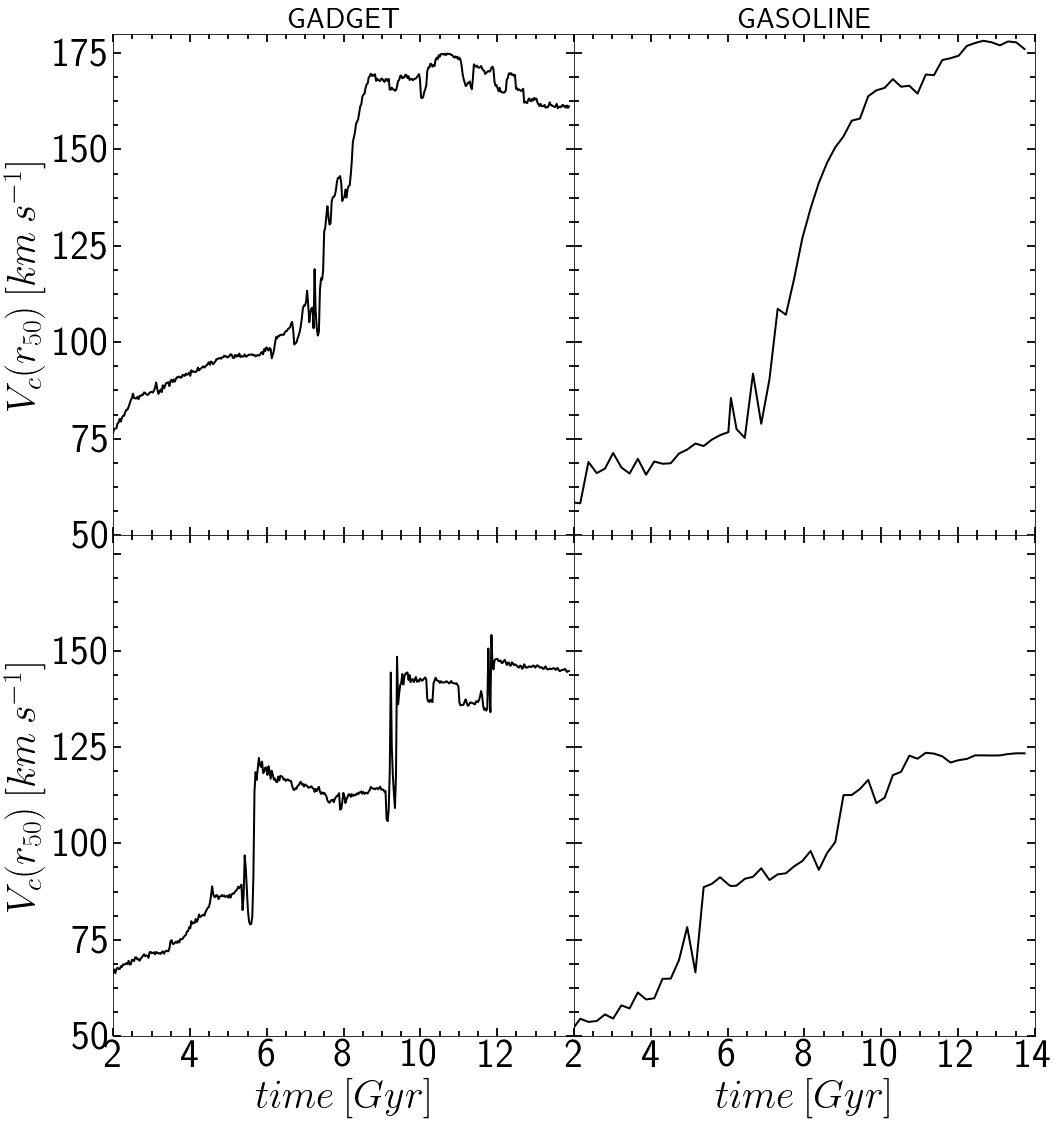

In [18]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, Vr50_M31gd,'-', lw=2, color = 'k')
ax[0,0].set_xlim(2,14)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(50,180)
ax[0,0].set_yticks([50,75,100,125,150,175])
ax[0,0].set_yticklabels([50,75,100,125,150,175])
ax[0,0].set_ylabel(r'$V_{c}(r_{50})\: [km\:s^{-1}]$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, Vr50_M31gs,'-', lw=2, color = 'k')
ax[0,1].set_xlim(2,14)
ax[0,1].set_xticks([2,4,6,8,10,12,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(50,180)
ax[0,1].set_yticks([50,75,100,125,150,175])
ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, Vr50_MWgd,'-', lw=2, color = 'k')
ax[1,0].set_xlim(2,14)
ax[1,0].set_xticks([2,4,6,8,10,12,14])
ax[1,0].set_xticklabels([2,4,6,8,10,12])
ax[1,0].set_ylim(50,180)
ax[1,0].set_yticks([50,75,100,125,150,175])
ax[1,0].set_yticklabels([50,75,100,125,150])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$V_{c}(r_{50}) \: [km\:s^{-1}] $',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, Vr50_MWgs,'-', lw=2, color = 'k')
ax[1,1].set_xlim(2,14)
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
ax[1,1].set_ylim(50,180)
ax[1,1].set_yticks([50,75,100,125,150,175])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Vr50_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()


## M50 vs time

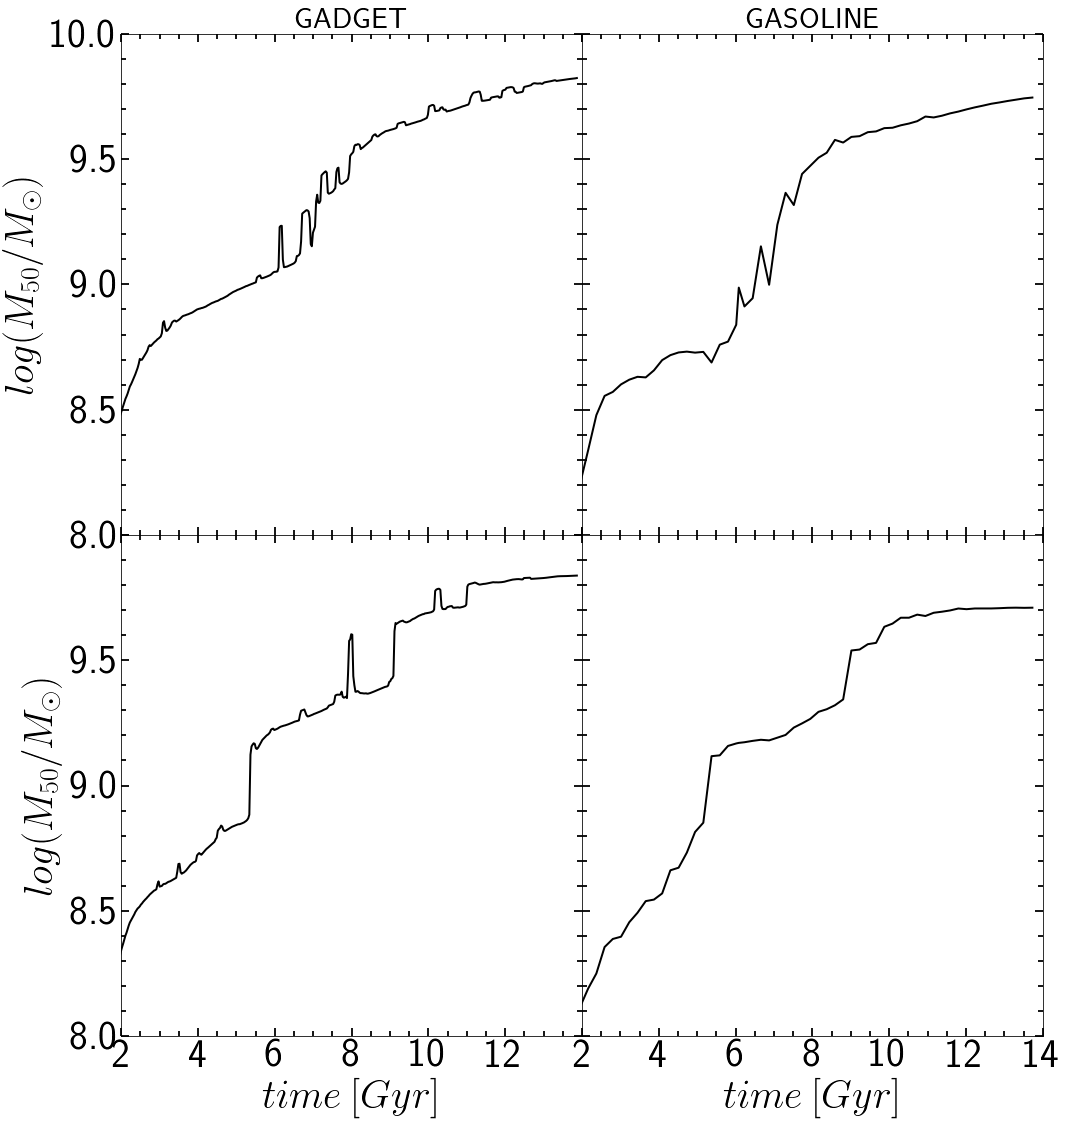

In [21]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, M50_M31gd,'-', lw=2, color = 'k')
ax[0,0].set_xlim(2,14)
ax[0,0].set_xticks([2,4,6,8,10,12,14])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(8,10)
ax[0,0].set_yticks([8.,8.5,9.,9.5,10.])
ax[0,0].set_yticklabels([8.,8.5,9.,9.5,10.])
ax[0,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, M50_M31gs,'-', lw=2, color = 'k')
ax[0,1].set_xlim(2,14)
ax[0,1].set_xticks([2,4,6,8,10,12,14])
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim(8,10)
ax[0,1].set_yticks([8.,8.5,9.,9.5,10.])
ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, M50_MWgd,'-', lw=2, color = 'k')
ax[1,0].set_xlim(2,14)
ax[1,0].set_xticks([2,4,6,8,10,12])
ax[1,0].set_xticklabels([2,4,6,8,10,12])
ax[1,0].set_ylim(8,10)
ax[1,0].set_yticks([8.,8.5,9.,9.5,10.])
ax[1,0].set_yticklabels([8.,8.5,9.,9.5])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, M50_MWgs,'-', lw=2, color = 'k')
ax[1,1].set_xlim(2,14)
ax[1,1].set_xticks([2,4,6,8,10,12,14])
ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
ax[1,1].set_ylim(8,10)
ax[1,1].set_yticks([8.,8.5,9.,9.5])
ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/M50_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()


## Mgas_50/M50 vs time

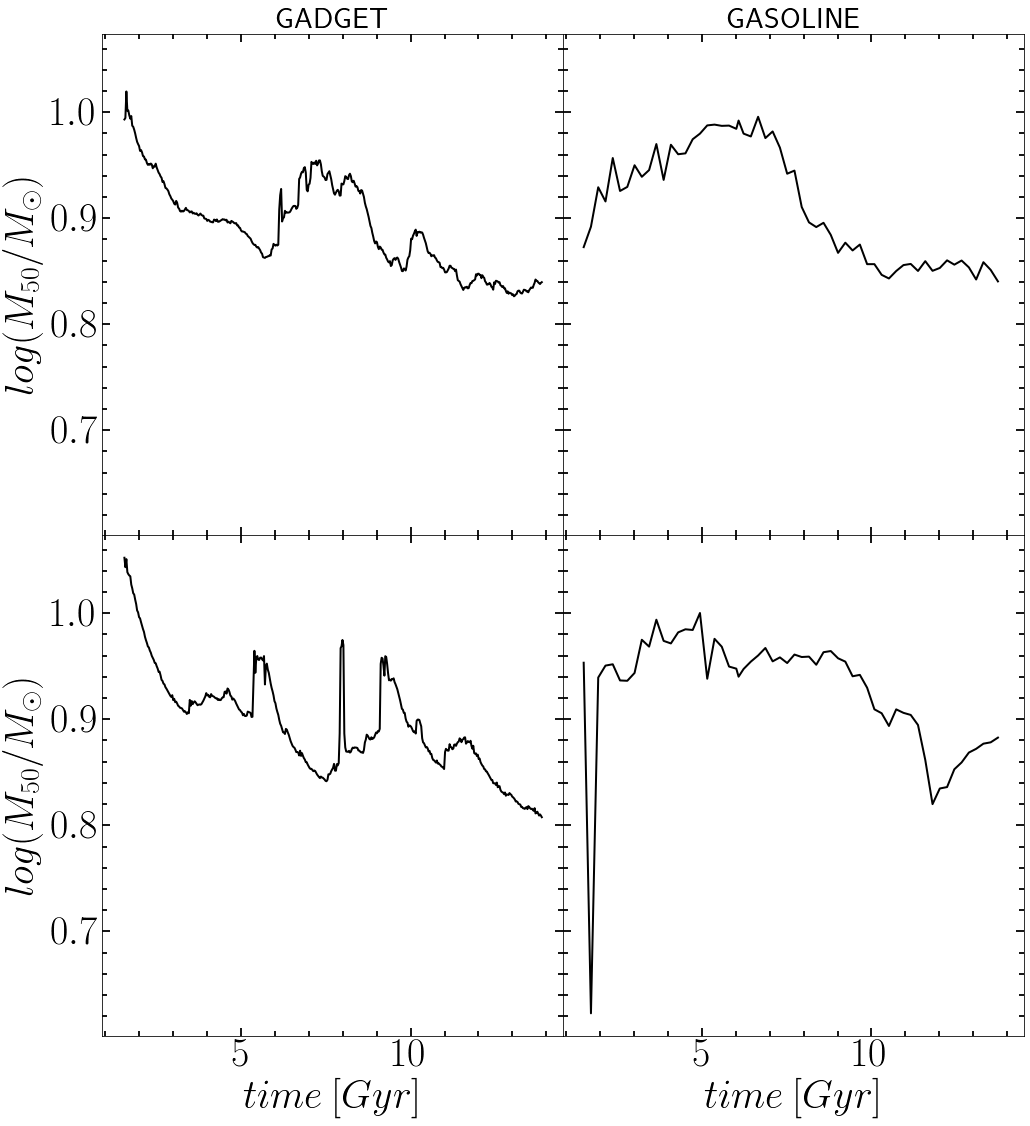

In [26]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, Mg50_M31gd/M50_M31gd,'-', lw=2, color = 'k')
# ax[0,0].set_xlim(2,14)
# ax[0,0].set_xticks([2,4,6,8,10,12,14])
# ax[0,0].set_xticklabels([])
# ax[0,0].set_ylim(8,10)
# ax[0,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,0].set_yticklabels([8.,8.5,9.,9.5,10.])
ax[0,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, Mg50_M31gs/M50_M31gs,'-', lw=2, color = 'k')
# ax[0,1].set_xlim(2,14)
# ax[0,1].set_xticks([2,4,6,8,10,12,14])
# ax[0,1].set_xticklabels([])
# ax[0,1].set_ylim(8,10)
# ax[0,1].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, Mg50_MWgd/M50_MWgd,'-', lw=2, color = 'k')
# ax[1,0].set_xlim(2,14)
# ax[1,0].set_xticks([2,4,6,8,10,12])
# ax[1,0].set_xticklabels([2,4,6,8,10,12])
# ax[1,0].set_ylim(8,10)
# ax[1,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[1,0].set_yticklabels([8.,8.5,9.,9.5])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, Mg50_MWgs/M50_MWgs,'-', lw=2, color = 'k')
# ax[1,1].set_xlim(2,14)
# ax[1,1].set_xticks([2,4,6,8,10,12,14])
# ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
# ax[1,1].set_ylim(8,10)
# ax[1,1].set_yticks([8.,8.5,9.,9.5])
# ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Mgas50_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

## Mdrk_50/M50 vs time

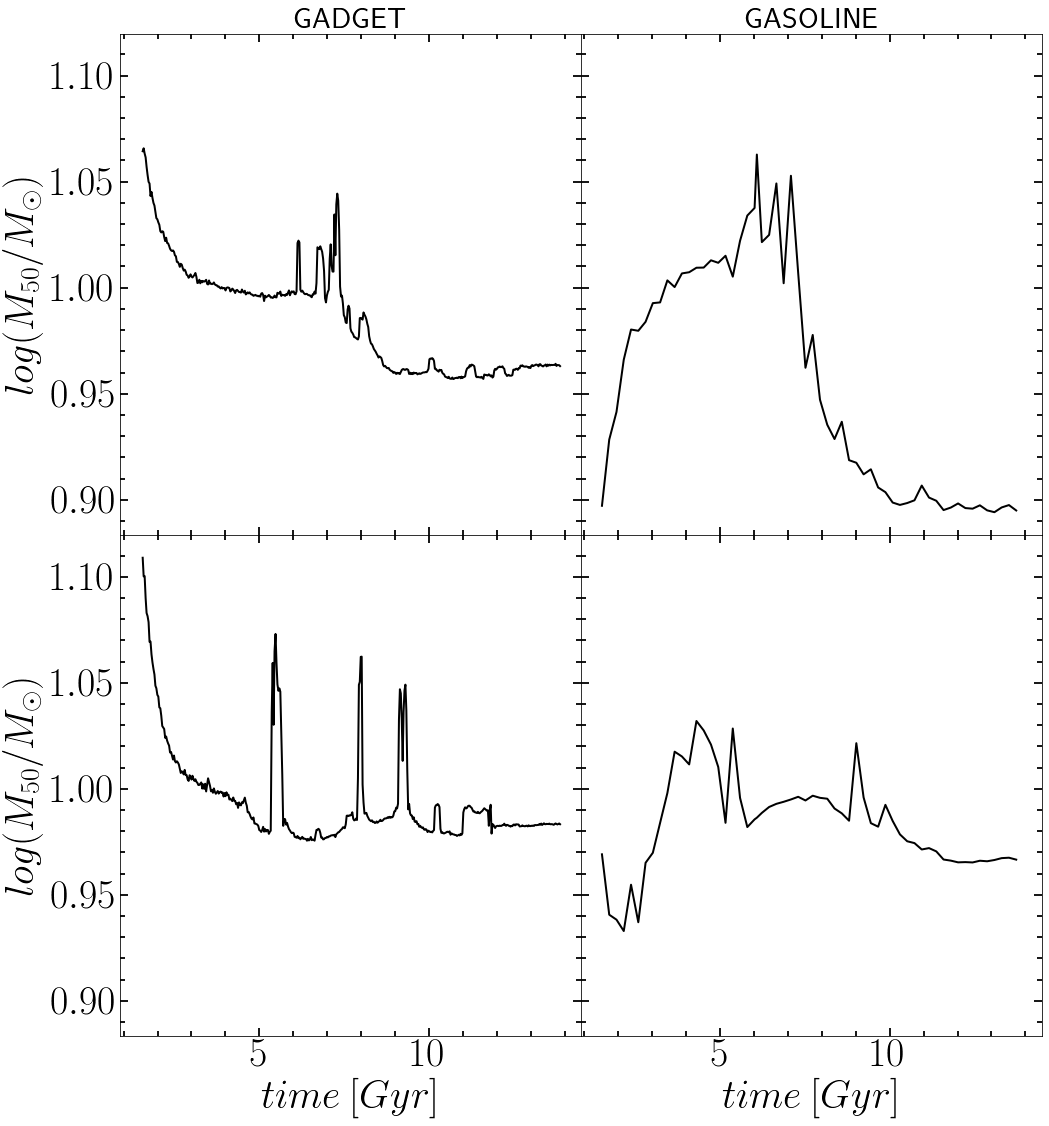

In [25]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, Mdm50_M31gd/M50_M31gd,'-', lw=2, color = 'k')
# ax[0,0].set_xlim(2,14)
# ax[0,0].set_xticks([2,4,6,8,10,12,14])
# ax[0,0].set_xticklabels([])
# ax[0,0].set_ylim(8,10)
# ax[0,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,0].set_yticklabels([8.,8.5,9.,9.5,10.])
ax[0,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, Mdm50_M31gs/M50_M31gs,'-', lw=2, color = 'k')
# ax[0,1].set_xlim(2,14)
# ax[0,1].set_xticks([2,4,6,8,10,12,14])
# ax[0,1].set_xticklabels([])
# ax[0,1].set_ylim(8,10)
# ax[0,1].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, Mdm50_MWgd/M50_MWgd,'-', lw=2, color = 'k')
# ax[1,0].set_xlim(2,14)
# ax[1,0].set_xticks([2,4,6,8,10,12])
# ax[1,0].set_xticklabels([2,4,6,8,10,12])
# ax[1,0].set_ylim(8,10)
# ax[1,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[1,0].set_yticklabels([8.,8.5,9.,9.5])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, Mdm50_MWgs/M50_MWgs,'-', lw=2, color = 'k')
# ax[1,1].set_xlim(2,14)
# ax[1,1].set_xticks([2,4,6,8,10,12,14])
# ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
# ax[1,1].set_ylim(8,10)
# ax[1,1].set_yticks([8.,8.5,9.,9.5])
# ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Mdrk50_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

In [31]:
q_M31gd = 1 + 10**Mg50_M31gd/10**M50 + 10**Mdm50_M31gd/10**M50
q_MWgd  = 1 + 10**Mg50_MWgd/10**M50  + 10**Mdm50_MWgd/10**M50
q_M31gs = 1 + 10**Mg50_M31gs/10**M50 + 10**Mdm50_M31gs/10**M50
q_MWgs  = 1 + 10**Mg50_MWgs/10**M50  + 10**Mdm50_MWgs/10**M50

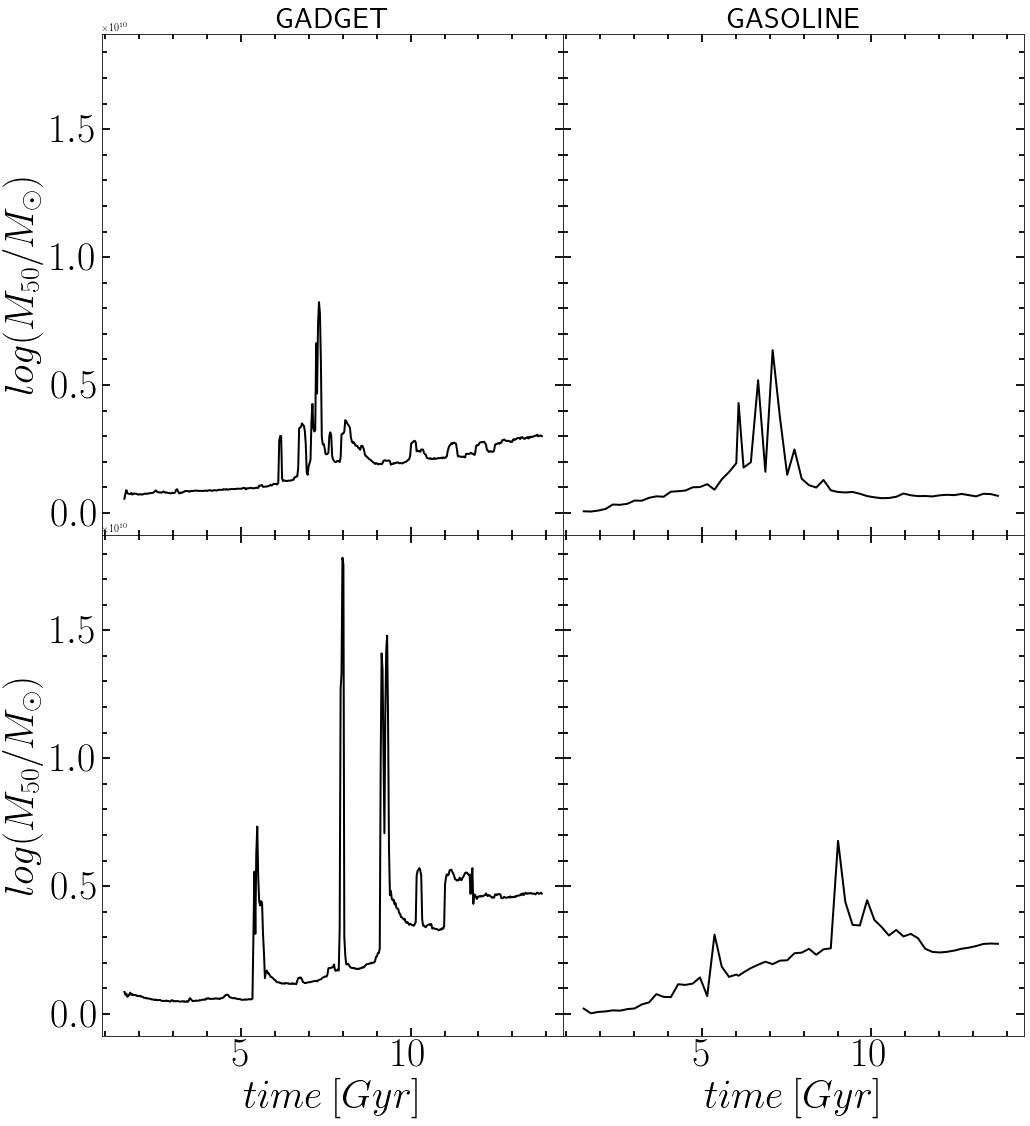

In [32]:
#-----grafico-----------
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= -0.3)
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.90, top = 0.95, wspace=0, hspace= 0)



# ax[0,0].plot(bines, np.log10(density_M31gd*1e10),'-', lw=2, color = 'k')
ax[0,0].plot(time_M31gd, q_M31gd,'-', lw=2, color = 'k')
# ax[0,0].set_xlim(2,14)
# ax[0,0].set_xticks([2,4,6,8,10,12,14])
# ax[0,0].set_xticklabels([])
# ax[0,0].set_ylim(8,10)
# ax[0,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,0].set_yticklabels([8.,8.5,9.,9.5,10.])
ax[0,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
# ax[0,0].plot(0,0,'k+', markersize=20, color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#---------------------------------

ax[0,1].plot(time_M31gs, q_M31gs,'-', lw=2, color = 'k')
# ax[0,1].set_xlim(2,14)
# ax[0,1].set_xticks([2,4,6,8,10,12,14])
# ax[0,1].set_xticklabels([])
# ax[0,1].set_ylim(8,10)
# ax[0,1].set_yticks([8.,8.5,9.,9.5,10.])
# ax[0,1].set_yticklabels([])
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].text(4, 9.75,'A', fontsize=30, color='k', ha='center', va='center') 
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)

#---------------------------------

ax[1,0].plot(time_MWgd, q_MWgd,'-', lw=2, color = 'k')
# ax[1,0].set_xlim(2,14)
# ax[1,0].set_xticks([2,4,6,8,10,12])
# ax[1,0].set_xticklabels([2,4,6,8,10,12])
# ax[1,0].set_ylim(8,10)
# ax[1,0].set_yticks([8.,8.5,9.,9.5,10.])
# ax[1,0].set_yticklabels([8.,8.5,9.,9.5])
ax[1,0].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,0].set_ylabel(r'$log(M_{50}/M_{\odot})$',fontsize=40)
# ax[1,0].set_yscale('log')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center')

#---------------------------------

ax[1,1].plot(time_MWgs, q_MWgs,'-', lw=2, color = 'k')
# ax[1,1].set_xlim(2,14)
# ax[1,1].set_xticks([2,4,6,8,10,12,14])
# ax[1,1].set_xticklabels([2,4,6,8,10,12,14])
# ax[1,1].set_ylim(8,10)
# ax[1,1].set_yticks([8.,8.5,9.,9.5])
# ax[1,1].set_yticklabels([])
ax[1,1].set_xlabel(r'$time \: [Gyr]$', fontsize=40)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,1].text(4, 9.75,'B', fontsize=30, color='k', ha='center', va='center') 
# ax[1,1].plot(0,0,'k+', markersize=20, color='k')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/cociente_time.pdf', dpi = 100, xxbox_inches='tight')
plt.show()